In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [29]:
df = pd.read_csv("D:/telco_churn.csv")  
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)

print("Shape:", df.shape)
df.head()

Shape: (5043, 22)


,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,False,True,False,1,False,NaN,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,3,7795-CFOCW,Male,False,False,False,45,False,NaN,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [31]:
df["Churn"]=df["Churn"].astype(str).str.strip().str.lower()
print(df['Churn'].value_counts())
mapping = {
    "false": 0,'yes':1,
    "true": 1,"no": 0, "nan": 0}
df["Churn"] = df["Churn"].map(mapping)
df["Churn"].value_counts()

Churn
false    2219
no       1487
true      780
yes       556
nan         1
Name: count, dtype: int64


Churn
0    3707
1    1336
Name: count, dtype: int64

In [33]:
X = df.drop(columns=["Churn"])
y = df["Churn"]


customer_ids = X["customerID"].copy()


X = X.drop(columns=["customerID"])

In [35]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

Categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical: ['Unnamed: 0', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (4034, 20) Test: (1009, 20)


In [39]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

In [41]:

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1       :", f1_score(y_test, y_pred_lr))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_lr))


Logistic Regression Results
Accuracy : 0.798810703666997
Precision: 0.6322314049586777
Recall   : 0.5730337078651685
F1       : 0.6011787819253438
ROC-AUC  : 0.8487840334352947


C:\anacondas\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


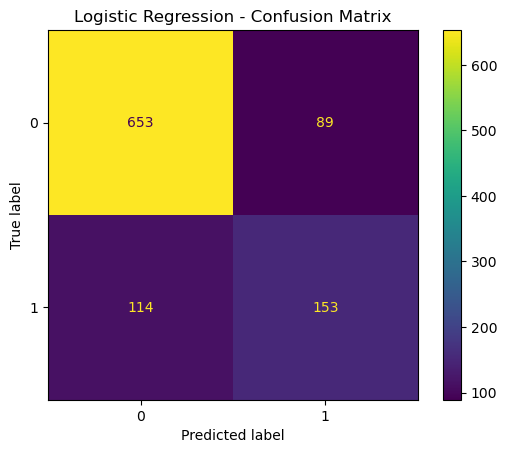

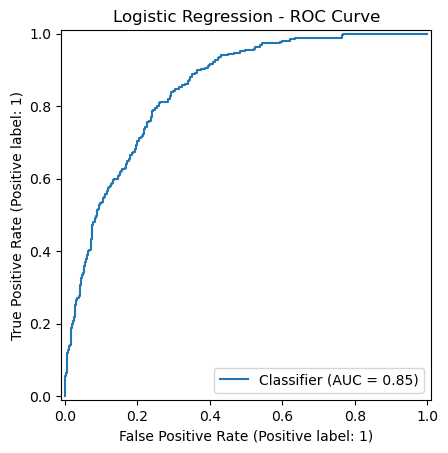

In [43]:

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Logistic Regression - ROC Curve")
plt.show()


In [45]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1       :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_rf))



Random Forest Results
Accuracy : 0.7958374628344896
Precision: 0.6405529953917051
Recall   : 0.5205992509363296
F1       : 0.5743801652892562
ROC-AUC  : 0.8400844968048699


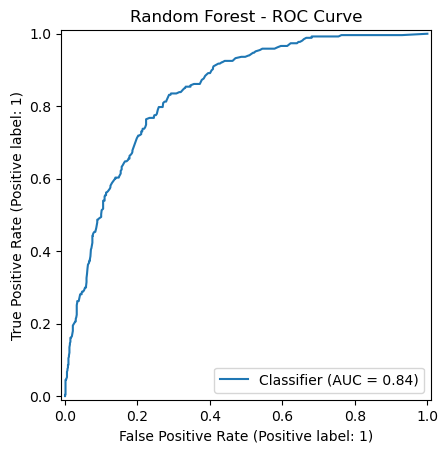

In [47]:
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest - ROC Curve")
plt.show()

In [49]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    "F1": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf)
    ],
}).sort_values(by="ROC-AUC", ascending=False)

results

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.798811,0.632231,0.573034,0.601179,0.848784
1,Random Forest,0.795837,0.640553,0.520599,0.574380,0.840084


In [51]:
ohe = rf.named_steps["preprocess"].named_transformers_["cat"]
feature_names_cat = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([feature_names_cat, np.array(num_cols)])


rf_model = rf.named_steps["model"]
importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp.head(15)

,feature,importance
75,tenure,0.107560
77,TotalCharges,0.106002
76,MonthlyCharges,0.097770
74,Unnamed: 0,0.079657
63,Contract_Month-to-month,0.071843
65,Contract_Two year,0.036961
25,InternetService_Fiber optic,0.036355
72,PaymentMethod_Electronic check,0.029779
64,Contract_One year,0.015381
24,InternetService_DSL,0.014687


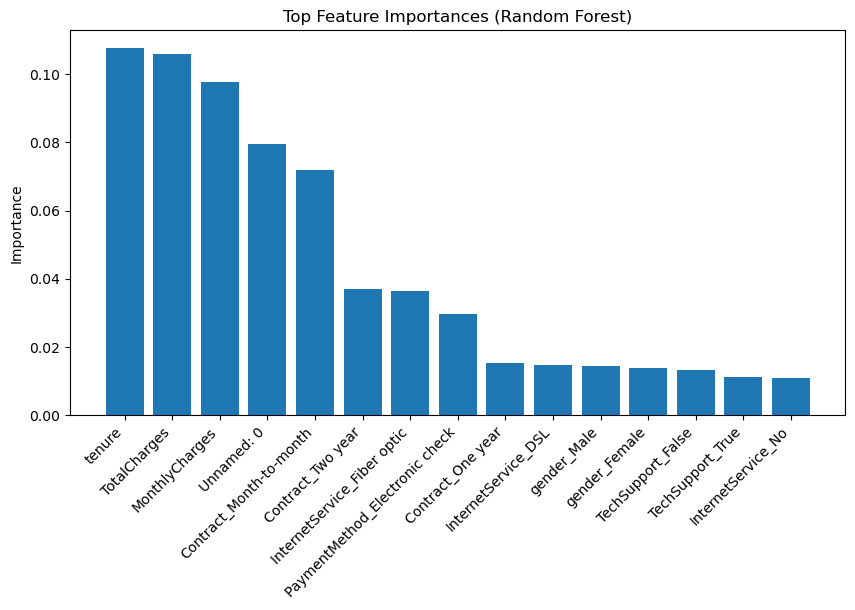

In [53]:
topN = 15
plt.figure(figsize=(10,5))
plt.bar(feat_imp["feature"].head(topN).astype(str), feat_imp["importance"].head(topN))
plt.title("Top Feature Importances (Random Forest)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.show()

In [55]:
all_proba = rf.predict_proba(X)[:, 1]

risk_table = pd.DataFrame({
    "customerID": customer_ids,
    "churn_probability": all_proba
}).sort_values(by="churn_probability", ascending=False)

risk_table.head(20)

,customerID,churn_probability
4267,0328-GRPMV,1.000000
4933,6502-MJQAE,0.996667
3662,3244-DCJWY,0.996667
4491,9728-FTTVZ,0.996667
4924,6457-GIRWB,0.996667
4488,0488-GSLFR,0.996667
4590,1031-IIDEO,0.993333
4764,7660-HDPJV,0.993333
3782,4871-JTKJF,0.990000
4816,2446-PLQVO,0.990000
